In [25]:
import pandas as pd
import numpy as np
import seaborn as sn
import calendar
from matplotlib import pyplot as plt
from datetime import timedelta
plt.style.use('seaborn')
%matplotlib inline

# Analysis of Cycling Data

## Loading Data

The first dataset is an export of my ride data from [Strava](https://strava.com/), an online social 
network site for cycling and other sports.  This data is a log of every ride since the start of 2018
and contains summary data like the distance and average speed.  It was exported using 
the script `stravaget.py` which uses the stravalib module to read data. Some details of
the fields exported by that script can be seen in [the documentation for stravalib](https://pythonhosted.org/stravalib/api.html#stravalib.model.Activity). 

The exported data is a CSV file so that's easy to read, however the date information in the file is 
recorded in a different timezone (UTC) so we need to do a bit of conversion.  In reading the data I'm
setting the index of the data frame to be the datetime of the ride. 

In [26]:
strava = pd.read_csv('data/strava_export.csv', index_col='date', parse_dates=True)
strava.index = strava.index.tz_convert('UTC')
strava.head()

,average_heartrate,average_temp,average_watts,device_watts,distance,elapsed_time,elevation_gain,kudos,moving_time,workout_type
date,,,,,,,,,,
2018-01-02 20:47:51+00:00,100.6,21.0,73.8,False,15.2,94,316.00 m,10,73,Ride
2018-01-04 01:36:53+00:00,NaN,24.0,131.7,False,18.0,52,236.00 m,5,46,Ride
2018-01-04 02:56:00+00:00,83.1,25.0,13.8,False,0.0,3,0.00 m,2,2,Ride
2018-01-04 05:37:04+00:00,110.1,24.0,113.6,False,22.9,77,246.00 m,8,64,Ride
2018-01-05 19:22:46+00:00,110.9,20.0,147.7,True,58.4,189,676.00 m,12,144,Ride


The second dataset comes from an application called [GoldenCheetah](https://www.goldencheetah.org/) which provides
some analytics services over ride data.  This has some of the same fields but adds a lot of analysis of the 
power, speed and heart rate data in each ride.  This data overlaps with the Strava data but doesn't include all 
of the same rides. 

Again we create an index using the datetime for each ride, this time combining two columns in the data (date and time) 
and localising to Sydney so that the times match those for the Strava data. 

In [27]:
cheetah = pd.read_csv('data/cheetah.csv', skipinitialspace=True)
cheetah.index = pd.to_datetime(cheetah['date'] + ' ' + cheetah['time'])
cheetah.index = cheetah.index.tz_localize('Australia/Sydney')
cheetah.head()

,date,time,filename,axPower,aPower Relative Intensity,aBikeScore,Skiba aVI,aPower Response Index,aIsoPower,aIF,...,Rest AVNN,Rest SDNN,Rest rMSSD,Rest PNN50,Rest LF,Rest HF,HRV Recovery Points,NP,IF,TSS
2018-01-28 06:39:49+11:00,01/28/18,06:39:49,2018_01_28_06_39_49.json,202.211,0.75452,16.6520,1.31920,1.67755,223.621,0.83441,...,0,0,0,0,0,0,0,222.856,0.83155,20.2257
2018-01-28 07:01:32+11:00,01/28/18,07:01:32,2018_01_28_07_01_32.json,226.039,0.84343,80.2669,1.21137,1.54250,246.185,0.91860,...,0,0,0,0,0,0,0,245.365,0.91554,94.5787
2018-02-01 08:13:34+11:00,02/01/18,08:13:34,2018_02_01_08_13_34.json,0.000,0.00000,0.0000,0.00000,0.00000,0.000,0.00000,...,0,0,0,0,0,0,0,0.000,0.00000,0.0000
2018-02-06 08:06:42+11:00,02/06/18,08:06:42,2018_02_06_08_06_42.json,221.672,0.82714,78.8866,1.35775,1.86002,254.409,0.94929,...,0,0,0,0,0,0,0,253.702,0.94665,98.3269
2018-02-07 17:59:05+11:00,02/07/18,17:59:05,2018_02_07_17_59_05.json,218.211,0.81422,159.4590,1.47188,1.74658,233.780,0.87231,...,0,0,0,0,0,0,0,232.644,0.86808,171.0780


The GoldenCheetah data contains many many variables (columns) and I won't go into all of them here. Some
that are of particular interest for the analysis below are:

Here are definitions of some of the more important fields in the data. Capitalised fields come from the GoldenCheetah data
while lowercase_fields come from Strava. There are many cases where fields are duplicated and in this case the values
should be the same, although there is room for variation as the algorithm used to calculate them could be different
in each case. 

  * Duration - overall duration of the ride, should be same as elapsed_time
  * Time Moving - time spent moving (not resting or waiting at lights), should be the same as moving_time
  * Elevation Gain - metres climbed over the ride
  * Average Speed - over the ride
  * Average Power - average power in watts as measured by a power meter, relates to how much effort is being put in to the ride, should be the same as  * average_watts' from Strava
  * Nonzero Average Power - same as Average Power but excludes times when power is zero from the average
  * Average Heart Rate - should be the same as average_heartrate
  * Average Cadence - cadence is the rotations per minute of the pedals
  * Average Temp - temperature in the environment as measured by the bike computer (should be same as average_temp)
  * VAM - average ascent speed - speed up hills
  * Calories (HR) - Calorie expendature as estimated from heart rate data
  * 1 sec Peak Power - this and other  'Peak Power' measures give the maximum power output in the ride over this time period.  Will be higher for shorter periods. High values in short periods would come from a very 'punchy' ride with sprints for example.
  * 1 min Peak Hr - a similar measure relating to Heart Rate
  * NP - Normalised Power, a smoothed average power measurement, generally higher than Average Power 
  * TSS - Training Stress Score, a measure of how hard a ride this was
  * device_watts - True if the power (watts) measures were from a power meter, False if they were estimated
  * distance - distance travelled in Km
  * kudos - likes from other Strava users (social network)
  * workout_type - one of  'Race',  'Workout' or  'Ride'
  
  
Some of the GoldenCheetah parameters are defined [in thier documentation](https://github.com/GoldenCheetah/GoldenCheetah/wiki/UG_Glossary).  

## Your Tasks

Your first task is to combine these two data frames using the [`join` method of Pandas](https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html#joining-on-index).   The goal is to keep only those rows of data 
that appear in __both__ data frames so that we have complete data for every row.  

In [28]:
str_cth_join=strava.join(cheetah,how='inner')
str_cth_join

,average_heartrate,average_temp,average_watts,device_watts,distance,elapsed_time,elevation_gain,kudos,moving_time,workout_type,...,Rest AVNN,Rest SDNN,Rest rMSSD,Rest PNN50,Rest LF,Rest HF,HRV Recovery Points,NP,IF,TSS
2018-01-27 19:39:49+00:00,120.6,21.0,153.4,True,7.6,17,95.00 m,4,17,Ride,...,0,0,0,0,0,0,0,222.856,0.831550,20.2257
2018-01-27 20:01:32+00:00,146.9,22.0,187.7,True,38.6,67,449.00 m,19,67,Race,...,0,0,0,0,0,0,0,245.365,0.915540,94.5787
2018-01-31 21:13:34+00:00,109.8,19.0,143.0,False,26.3,649,612.00 m,6,113,Ride,...,0,0,0,0,0,0,0,0.000,0.000000,0.0000
2018-02-05 21:06:42+00:00,119.3,19.0,165.9,True,24.3,69,439.00 m,6,65,Ride,...,0,0,0,0,0,0,0,253.702,0.946650,98.3269
2018-02-07 06:59:05+00:00,124.8,20.0,151.0,True,47.1,144,890.00 m,10,134,Ride,...,0,0,0,0,0,0,0,232.644,0.868080,171.0780
2018-02-09 19:18:03+00:00,123.0,20.0,145.9,True,59.8,193,656.00 m,22,139,Ride,...,0,0,0,0,0,0,0,212.726,0.793750,147.7970
2018-02-10 20:21:37+00:00,103.9,17.0,134.9,True,7.8,19,92.00 m,8,18,Ride,...,0,0,0,0,0,0,0,192.117,0.716850,15.7590
2018-02-10 20:46:02+00:00,152.1,19.0,198.9,True,31.0,49,387.00 m,21,49,Race,...,0,0,0,0,0,0,0,244.500,0.912310,69.2902
2018-02-12 21:19:36+00:00,113.3,25.0,141.4,False,25.0,631,559.00 m,12,105,Ride,...,0,0,0,0,0,0,0,0.000,0.000000,0.0000
2018-02-14 20:07:12+00:00,125.3,19.0,148.9,True,47.8,143,922.00 m,6,132,Ride,...,0,0,0,0,0,0,0,222.957,0.831930,155.9740


# ANALYSIS

We have done an inner join between the two given datasets- strava and cheetah and stored it in dataframe str_cth_join. As a result of the inner join we have 243 rows and 372 columns.

## Required Analysis

1. Remove rides with no measured power (where device_watts is False) - these are commutes or MTB rides
* Look at the distributions of some key variables: time, distance, average speed, average power, TSS. Are they normally distributed? Skewed? 
* Explore the relationships between the following variables. Are any of them corrolated with each other (do they vary together in a predictable way)? Can you explain any relationships you observe?  
    * Distance
    * Moving Time
    * Average Speed
    * Heart Rate
    * Power (watts)
    * Normalised power (NP)
    * Training Stress Score
    * Elevation Gain
* We want to explore the differences between the three categories: `Race`, `Workout` and `Ride`.
    * Use scatter plots with different colours for each category to explore how these categories differ.  
    * Use histograms or box plots to visualise the different distributions of a variable for the three categories.
    * In both cases, experiment with different variables but only include those that are interesting in your final notebook (if none are interesting, show us a representative example).


## Challenge

* What leads to more `kudos`? Is there anything to indicate which rides are more popular? Explore the relationship between the main variables and kudos. Show a plot and comment on any relationship you observe. 

* Generate a plot that summarises the number of km ridden each month over the period of the data. Overlay this with the _sum_ of the Training Stress Score and the _average_ of the Average Speed to generate an overall summary of activity.

* Generate a similar graph but one that shows the activity over a given month, with the sum of the values for each day of the month shown.  So, if there are two rides on a given day, the graph should show the sum of the distances etc for these rides.

Hint: to generate these summary plots you need to use the [timeseries/date functionality](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html) in Pandas to generate a new data frame containing the required data.  

__Note:__ once you have completed these steps you can remove this cell.  Use the text as a starting point for the documentation of your workflow and discussion of results.


In [29]:
result2=str_cth_join[(str_cth_join['device_watts']==True)]
result2.dropna()

,average_heartrate,average_temp,average_watts,device_watts,distance,elapsed_time,elevation_gain,kudos,moving_time,workout_type,...,Rest AVNN,Rest SDNN,Rest rMSSD,Rest PNN50,Rest LF,Rest HF,HRV Recovery Points,NP,IF,TSS
2018-01-27 19:39:49+00:00,120.6,21.0,153.4,True,7.6,17,95.00 m,4,17,Ride,...,0,0,0,0,0,0,0,222.856,0.831550,20.2257
2018-01-27 20:01:32+00:00,146.9,22.0,187.7,True,38.6,67,449.00 m,19,67,Race,...,0,0,0,0,0,0,0,245.365,0.915540,94.5787
2018-02-05 21:06:42+00:00,119.3,19.0,165.9,True,24.3,69,439.00 m,6,65,Ride,...,0,0,0,0,0,0,0,253.702,0.946650,98.3269
2018-02-07 06:59:05+00:00,124.8,20.0,151.0,True,47.1,144,890.00 m,10,134,Ride,...,0,0,0,0,0,0,0,232.644,0.868080,171.0780
2018-02-09 19:18:03+00:00,123.0,20.0,145.9,True,59.8,193,656.00 m,22,139,Ride,...,0,0,0,0,0,0,0,212.726,0.793750,147.7970
2018-02-10 20:21:37+00:00,103.9,17.0,134.9,True,7.8,19,92.00 m,8,18,Ride,...,0,0,0,0,0,0,0,192.117,0.716850,15.7590
2018-02-10 20:46:02+00:00,152.1,19.0,198.9,True,31.0,49,387.00 m,21,49,Race,...,0,0,0,0,0,0,0,244.500,0.912310,69.2902
2018-02-14 20:07:12+00:00,125.3,19.0,148.9,True,47.8,143,922.00 m,6,132,Ride,...,0,0,0,0,0,0,0,222.957,0.831930,155.9740
2018-02-16 19:19:04+00:00,124.9,20.0,159.6,True,58.6,212,659.00 m,19,132,Ride,...,0,0,0,0,0,0,0,222.469,0.830110,154.5070
2018-02-17 19:06:26+00:00,123.7,17.0,158.7,True,20.1,49,244.00 m,8,46,Ride,...,0,0,0,0,0,0,0,211.950,0.790860,49.1852


# ANALYSIS

Rides with no measured power are removed i.e., device_watts = True imples it is measured from the power meter whereas False device_watts implies they are estimated so we are just keeping the rows with measured power and also dropping columsn with NaN values.

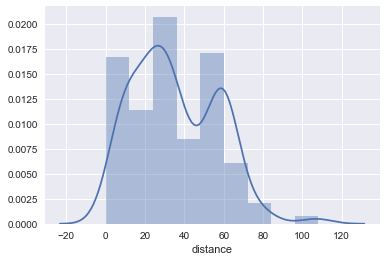

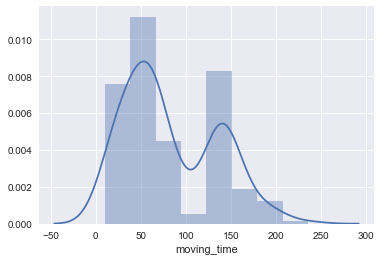

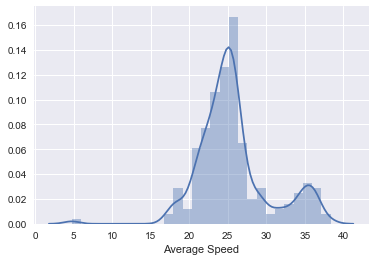

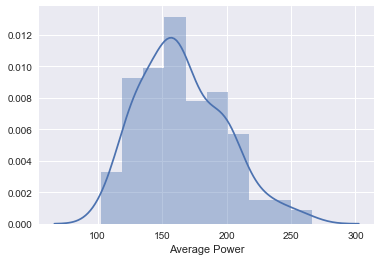

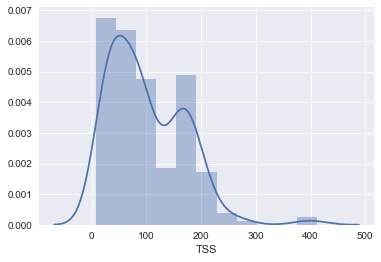

In [30]:
sn.distplot(result2['distance'])
plt.show()

sn.distplot(result2['moving_time'])
plt.show()

sn.distplot(result2['Average Speed'])
plt.show()


sn.distplot(result2['Average Power'])
plt.show()


sn.distplot(result2['TSS'])
plt.show()

# ANALYSIS

As per the metalib diagram , Distance & moving time can be intrepreted as bimodal .
Whereas Average Power and Average Speed can be considered as left skewed and TSS is right skewed

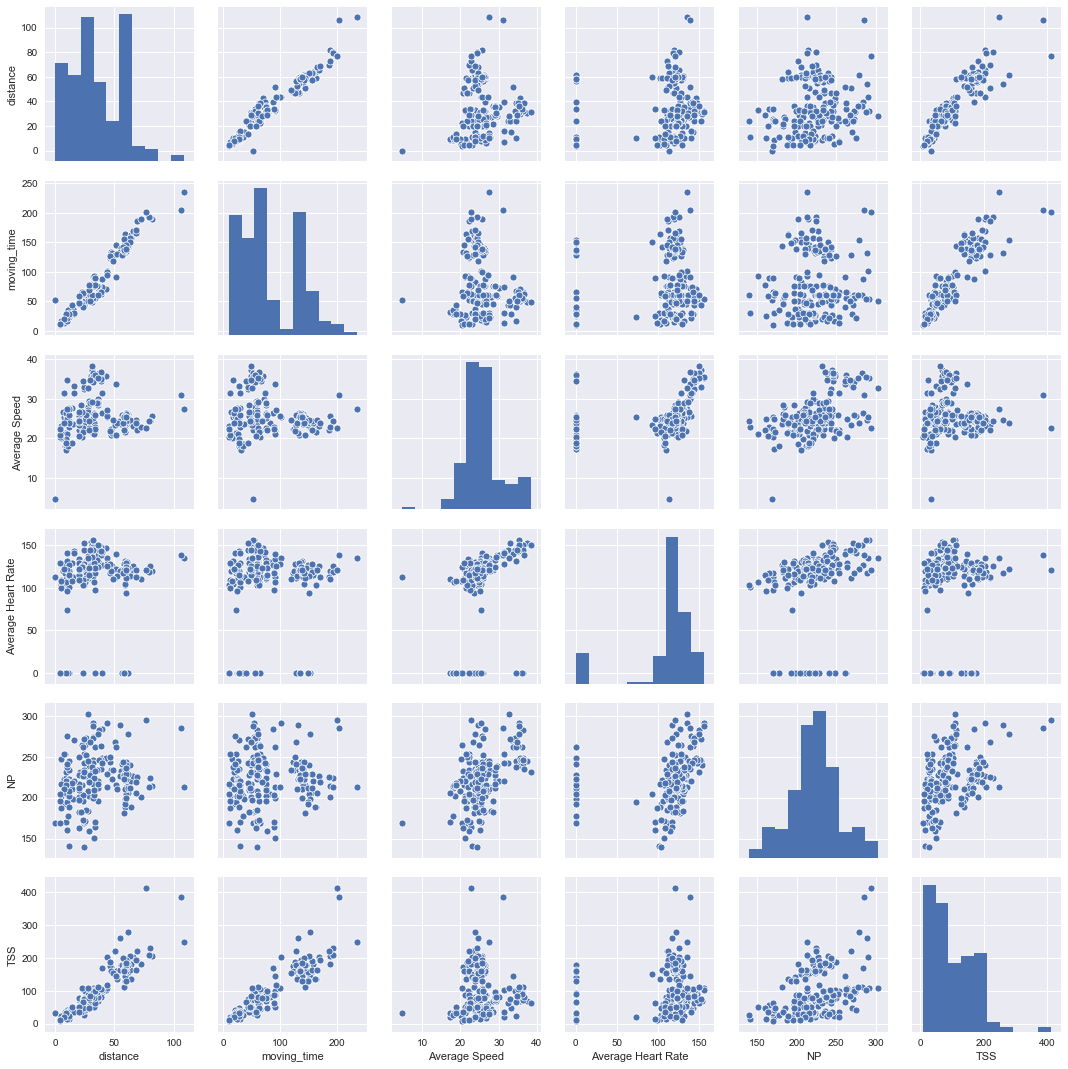

In [31]:
corr_result =result2 [["distance", "moving_time","Average Speed","Average Heart Rate","NP","TSS","elevation_gain"]]
sn.pairplot(corr_result)

# ANALYSIS
Pairplot has clearly shown the correlation between all required variables. We can say that distanc and moving time are highly correlated and it is obvious as well.
TSS and distance , TSS and moving time are also correlated but not as much distance and moving time are.

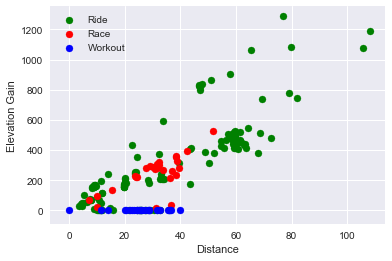

In [32]:
wride=result2[(result2['workout_type']=='Ride')]
wrace=result2[(result2['workout_type']=='Race')]
wworkout=result2[(result2['workout_type']=='Workout')]

plt.scatter(wride["distance"],wride["Elevation Gain"],color='green', label="Ride")
plt.scatter(wrace["distance"],wrace["Elevation Gain"],color='red', label="Race")
plt.scatter(wworkout["distance"],wworkout["Elevation Gain"],color='blue',label="Workout")
plt.xlabel("Distance")
plt.ylabel("Elevation Gain")
plt.legend()
plt.show()

# ANALYSIS
Scatter plot is used to depict how three workout categories are differ in terms of distance and elevation gain. Distance is the how far they travel from the starting time and elevation gain is how many meteres climbed during the ride.
Here, three workout categoires illustrates that highest number of metres are climber during __ride__ workout type and lowest metres are covered in __workout__ type of the cycling.

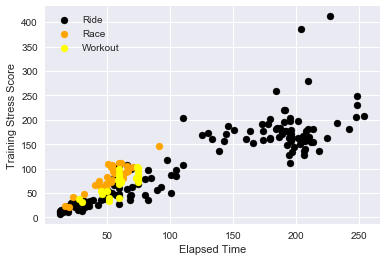

In [33]:
plt.scatter(wride["elapsed_time"],wride["TSS"],color='black', label="Ride")
plt.scatter(wrace["elapsed_time"],wrace["TSS"],color='orange', label="Race")
plt.scatter(wworkout["elapsed_time"],wworkout["TSS"],color='yellow',label="Workout")
plt.xlabel("Elapsed Time")
plt.ylabel("Training Stress Score")
plt.legend()
plt.show()

# ANALYSIS
Scatter plot is used to depict how three workout categories are differ in terms of elapsed_time and TSS. Elapsed time is the time taken for the ride and TSS stands for Trainig Stress Score , it detemrines how hard the ride was. Here, three workout categoires illustrates that as the time increases __ride__ type of workout becomes hard where other workout types are closely related of elapsed time and TSS .

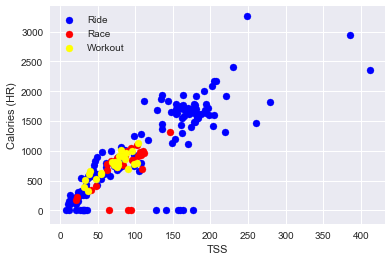

In [34]:
plt.scatter(wride["TSS"],wride["Calories (HR)"],color='blue', label="Ride")
plt.scatter(wrace["TSS"],wrace["Calories (HR)"],color='red', label="Race")
plt.scatter(wworkout["TSS"],wworkout["Calories (HR)"],color='yellow',label="Workout")
plt.xlabel("TSS")
plt.ylabel("Calories (HR)")
plt.legend()
plt.show()

# ANALYSIS

Scatter plot is used to depict how three workout categories are differ in terms of Calories (HR) and TSS.Calories (HR) is the calorie expendature as estimated from heart rate data. As the TSS increases in the __ride__ __workout__ calories count also increases and it makes senses because more power required more calories to be burnt. For the __race__ and __workout__ type also shows increase in the calories but less than __ride__ type.

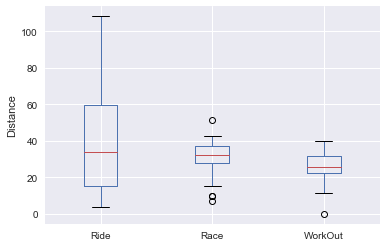

In [35]:
distdf=pd.concat([wride['Distance'],wrace['Distance'],wworkout['Distance']], axis=1, keys=['Ride', 'Race','WorkOut'])
distdf.boxplot()
plt.ylabel("Distance")
plt.show()

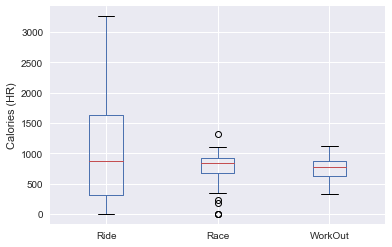

In [36]:
distdf=pd.concat([wride['Calories (HR)'],wrace['Calories (HR)'],wworkout['Calories (HR)']], axis=1, keys=['Ride', 'Race','WorkOut'])
distdf.boxplot()
plt.ylabel("Calories (HR)")
plt.show()

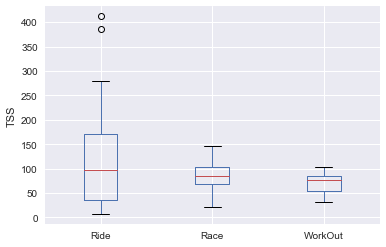

In [37]:
distdf=pd.concat([wride['TSS'],wrace['TSS'],wworkout['TSS']], axis=1, keys=['Ride', 'Race','WorkOut'])
distdf.boxplot()
plt.ylabel("TSS")
plt.show()

# CHALLENGE ANALYSIS

In [38]:
kudos_rel=[result2[result2.columns[1:]].corr()['kudos'][:]] #result2 , dataframe where only rides keep whose measeure power is True
kudos_rel_df = pd.DataFrame(kudos_rel)
kudos_rel_df=kudos_rel_df.loc[:,kudos_rel_df.gt(0.7).any()]
kudos_rel_df

,distance,kudos,Distance,Work,Aerobic TISS,P6 Time in Pace Zone,Distance Swim,L7 Time in Zone,TRIMP Zonal Points,W' Work,W2 W'bal Moderate Fatigue
kudos,0.752259,1.0,0.752355,0.710227,0.759824,0.715687,0.752355,0.714275,0.732845,0.729565,0.702977


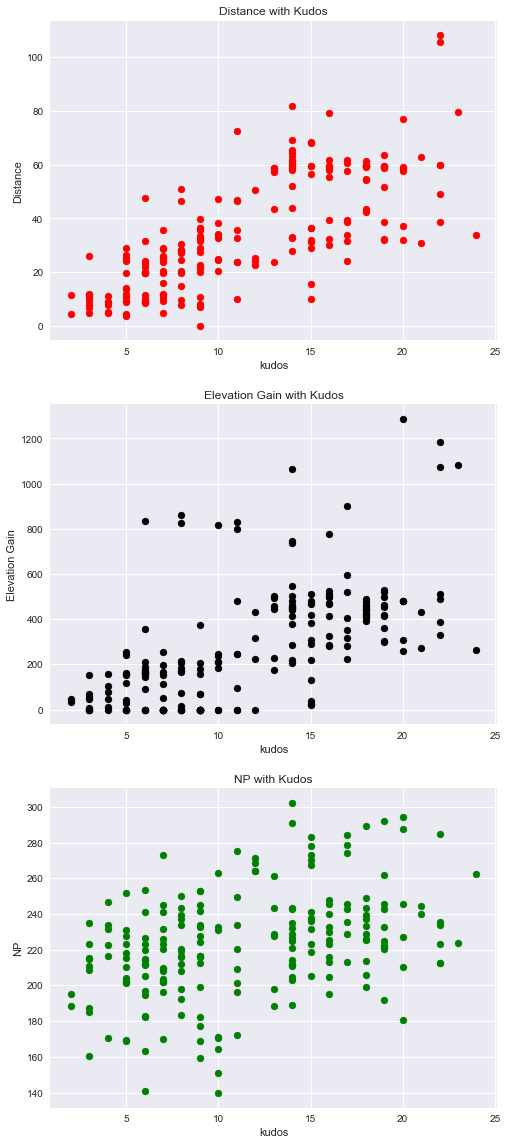

In [39]:
fig,axs=plt.subplots(3,1,figsize=(8,20))

#Kudos relationship with distance
axs[0].scatter(result2['kudos'], result2['Distance'], color='red')
axs[0].set_xlabel('kudos')
axs[0].set_ylabel('Distance')
axs[0].set_title('Distance with Kudos')

#Kudos relationship with Elevation Gain
axs[1].scatter(result2['kudos'], result2['Elevation Gain'], color='black')
axs[1].set_xlabel('kudos')
axs[1].set_ylabel('Elevation Gain')
axs[1].set_title('Elevation Gain with Kudos')

#Kudos relationship with NP
axs[2].scatter(result2['kudos'], result2['NP'], color='green')
axs[2].set_xlabel('kudos')
axs[2].set_ylabel('NP')
axs[2].set_title('NP with Kudos')
plt.show()

In [40]:
month_name=[]
for e in result2.index:
    month_name.append((calendar.month_name[e.month]))
result2.insert(2, "Month", month_name, True) 
month_df['distance']=result2.groupby(['Month']).distance.sum()
month_df['TSS']=result2.groupby(['Month']).TSS.sum()
month_df['Average Speed']=result2.groupby(['Month'])['Average Speed'].mean()
month_df

,distance,TSS,Average Speed
Month,,,
April,959.7,2728.7067,25.026845
August,186.7,650.2351,24.820900
December,463.5,1320.9536,26.542742
February,894.3,2516.9546,25.175459
January,420.6,1172.7407,24.688331
July,547.9,1477.5739,25.911157
June,653.4,1877.0106,26.842038
March,986.9,3038.2625,26.294552
May,896.4,2486.5636,26.147425


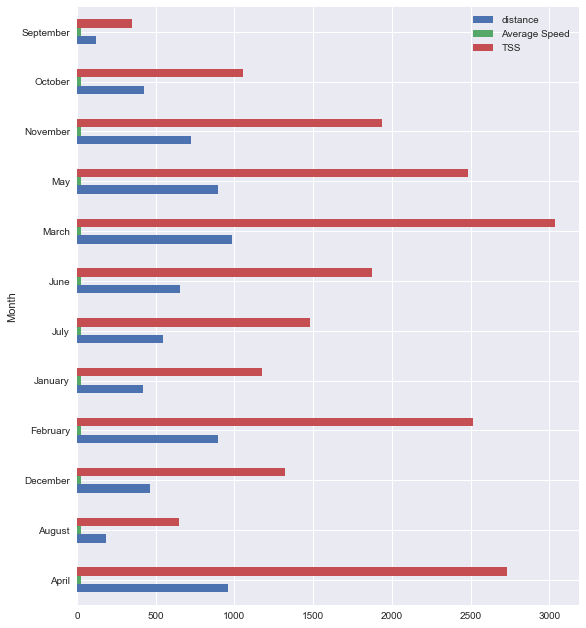

In [12]:
month_df.plot( y=["distance", "Average Speed", "TSS"], kind="barh")
plt.rcParams["figure.figsize"] = (9,11)
plt.legend(loc='best', prop={'size': 10})
plt.show()

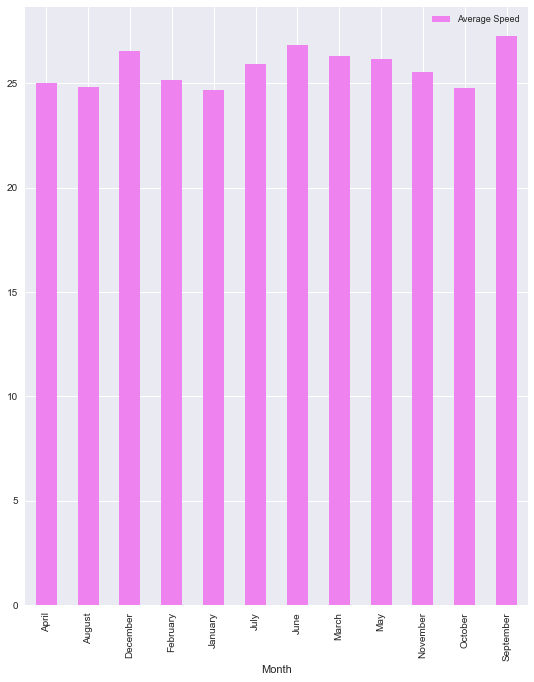

In [14]:
month_df.plot( y=["Average Speed"], kind="bar", color="violet")
plt.rcParams["figure.figsize"] = (9,9)
plt.legend(loc='best', prop={'size':9})
plt.show()